In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df

,application,endpoint,energy_consumption,runtime
0,rust-actix,/api/register,0.449358,0.148812
1,rust-actix,/api/register,0.433871,0.148895
2,rust-actix,/api/register,0.270844,0.094729
3,rust-actix,/api/register,0.479776,0.163467
4,rust-actix,/api/register,0.268833,0.092300
...,...,...,...,...
1955,javascript-express,/logout,0.096436,0.032214
1956,javascript-express,/logout,0.097559,0.032214
1957,javascript-express,/logout,0.096922,0.032214
1958,javascript-express,/logout,0.097086,0.032214


In [4]:
df.endpoint.unique().tolist()

['/api/register',
 '/api/msgs/user0',
 '/api/msgs',
 '/api/fllws/user',
 '/api/unfllws/user',
 '/api/latest',
 '/register',
 '/login',
 '/user/follow',
 '/add_message',
 '/public',
 '/user/user0',
 '/user/unfollow',
 '/logout']

In [5]:
df.application.unique().tolist()

['rust-actix',
 'ruby-sinatra',
 'go-gorilla',
 'go-gin',
 'python-flask',
 'c-sharp-razor',
 'javascript-express']

From what we can see then we have 4 different types of data:

- Application:
  - Formatted with `<programming_language>-<web_framework>`
- Endpoint:
  - the path of the endpoint like `/api/register`
- Energy_consumption:
  - the energy consumption of the endpoint in jules
  - Because of fysics we can not have negative energy consumption, so we can assume that the energy consumption is always positive.
- Runtime:
  - the time it took to run the endpoint in seconds
  - Because of fysics we can not have negative time, so we can assume that the time is always positive.


In [6]:
# check if all applications have the same number of endpoints
df.groupby('application').endpoint.nunique().reset_index().sort_values('endpoint', ascending=False)

,application,endpoint
0,c-sharp-razor,14
1,go-gin,14
2,go-gorilla,14
3,javascript-express,14
4,python-flask,14
5,ruby-sinatra,14
6,rust-actix,14


# H1
> The web framework `c-sharp-razor` consumes more energy than any other web framework in the dataset.

In [7]:
# Filter data for c-sharp-razor and other frameworks
c_sharp_razor_data = df[df['application'] == 'c-sharp-razor']['energy_consumption']
other_frameworks_data = df[df['application'] != 'c-sharp-razor']['energy_consumption']

# PyMC model
with pm.Model() as model_vs:
    # Priors for the means and standard deviations
    mu_csharp = pm.Normal('mu_csharp', mu=0, sigma=10)
    mu_other = pm.Normal('mu_other', mu=0, sigma=10)
    sigma_csharp = pm.HalfNormal('sigma_csharp', sigma=10)
    sigma_other = pm.HalfNormal('sigma_other', sigma=10)

    # Likelihoods for the observed data
    csharp_obs = pm.Normal('csharp_obs', mu=mu_csharp, sigma=sigma_csharp, observed=c_sharp_razor_data)
    other_obs = pm.Normal('other_obs', mu=mu_other, sigma=sigma_other, observed=other_frameworks_data)

    # Difference in means
    diff = pm.Deterministic('diff', mu_csharp - mu_other)

    # Sampling
    trace = pm.sample(1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_csharp, mu_other, sigma_csharp, sigma_other]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


In [8]:
with model_vs:
    model_vs_prior_pred = pm.sample_prior_predictive(samples = 400, random_seed = 42)

Sampling: [csharp_obs, mu_csharp, mu_other, other_obs, sigma_csharp, sigma_other]


In [9]:
model_vs_prior_pred.prior.sel(chain = 0)

<xarray.Dataset> Size: 18kB
Dimensions:       (draw: 400)
Coordinates:
    chain         int32 4B 0
  * draw          (draw) int32 2kB 0 1 2 3 4 5 6 ... 393 394 395 396 397 398 399
Data variables:
    sigma_other   (draw) float64 3kB 4.183 6.056 0.2879 ... 4.784 2.547 2.046
    mu_other      (draw) float64 3kB -1.004 14.6 -15.82 ... -2.07 -7.839 15.07
    sigma_csharp  (draw) float64 3kB 12.54 6.063 13.4 10.69 ... 1.489 6.364 7.85
    diff          (draw) float64 3kB -2.429 -31.21 11.96 ... 16.42 11.5 -43.31
    mu_csharp     (draw) float64 3kB -3.433 -16.61 -3.855 ... 14.35 3.66 -28.24
Attributes:
    created_at:                 2025-05-07T11:28:41.219469+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1

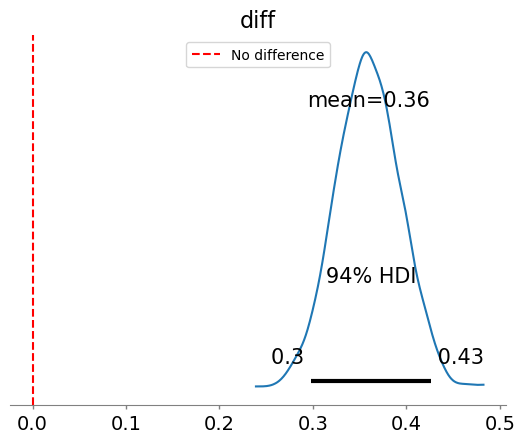

In [10]:
# Check the posterior probability that c-sharp-razor has higher energy consumption
az.plot_posterior(trace, var_names=['diff'])
plt.axvline(0, color='red', linestyle='--', label='No difference')
plt.legend()
plt.show()

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_csharp,0.689,0.034,0.625,0.752,0.0,0.0,6856.0,3483.0,1.0
mu_other,0.330,0.004,0.322,0.337,0.0,0.0,6511.0,3483.0,1.0
sigma_csharp,0.581,0.025,0.534,0.627,0.0,0.0,8159.0,3262.0,1.0
sigma_other,0.177,0.003,0.171,0.183,0.0,0.0,7966.0,2914.0,1.0
diff,0.359,0.035,0.298,0.426,0.0,0.0,6922.0,3588.0,1.0


We see a possitive `diff` and because we retracted the other frameworks from `c-sharp-razor` and the `diff` is positive we can assume that the web framework `c-sharp-razor` consumes more energy than any other web framework in the dataset.


In [12]:
framework_codes = pd.Categorical(df['application']).codes
c_sharp_razor_code = framework_codes[df['application'] == 'c-sharp-razor'][0]
"c-sharp-razor code: ", c_sharp_razor_code

('c-sharp-razor code: ', 0)

In [19]:
df["framework_code"] = framework_codes

with pm.Model() as model_categorical:
    # Priors for the means and standard deviations
    mu = pm.Normal('mu', mu=0, sigma=1, shape=len(df.application.unique()))
    sigma = pm.LogNormal('sigma', sigma=1, shape=len(df.application.unique()))

    # Likelihoods for the observed data
    obs = pm.Normal('obs', mu=mu[df['framework_code']], sigma=sigma[df['framework_code']], observed=df['energy_consumption'])

    # Difference in means
    diff = pm.Deterministic('diff', mu[c_sharp_razor_code] - mu)

    # Sampling
    trace_categorical = pm.sample(1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


In [18]:
az.summary(trace_categorical, var_names=['mu', 'sigma', 'diff'])

c:\Users\patr7\miniconda3\envs\prpro-2025\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.690,0.035,0.623,0.754,0.0,0.0,5847.0,3031.0,1.0
mu[1],0.319,0.010,0.301,0.338,0.0,0.0,6045.0,2968.0,1.0
mu[2],0.324,0.009,0.308,0.340,0.0,0.0,4896.0,2872.0,1.0
mu[3],0.206,0.009,0.189,0.224,0.0,0.0,6773.0,2550.0,1.0
mu[4],0.413,0.010,0.394,0.432,0.0,0.0,6352.0,3182.0,1.0
mu[5],0.409,0.012,0.386,0.432,0.0,0.0,6843.0,2564.0,1.0
mu[6],0.307,0.008,0.293,0.322,0.0,0.0,5698.0,2924.0,1.0
sigma[0],0.581,0.025,0.534,0.625,0.0,0.0,5916.0,2872.0,1.0
sigma[1],0.166,0.007,0.152,0.179,0.0,0.0,7398.0,3243.0,1.0
sigma[2],0.148,0.006,0.136,0.159,0.0,0.0,5914.0,3163.0,1.0


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

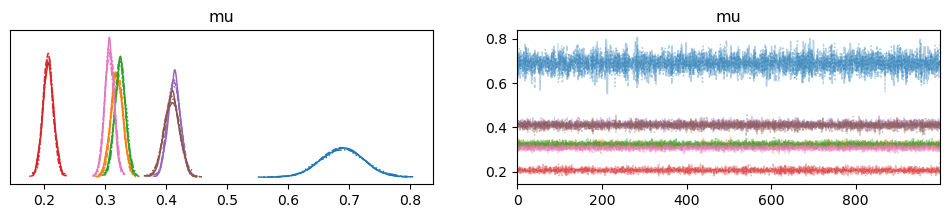

In [22]:
az.plot_trace(trace_categorical, var_names=["mu"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

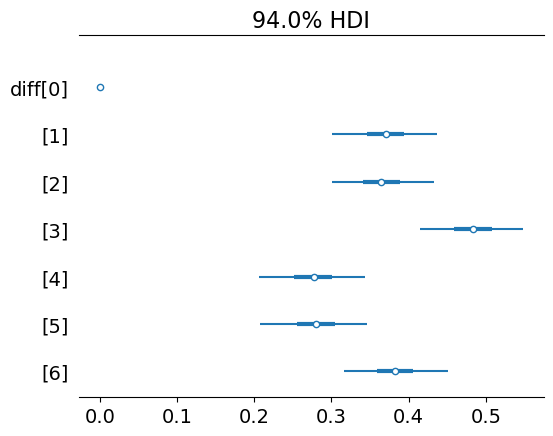

In [23]:
az.plot_forest(trace_categorical, var_names=["diff"], combined=True)

In [ ]:
# Check the posterior probability that c-sharp-razor has higher energy consumption
az.plot_posterior(trace_categorical, var_names=['diff0'])
# plt.axvline(0, color='red', linestyle='--', label='No difference')
# plt.legend()
# plt.show()

In [43]:
rng = np.random.default_rng(42)
with pm.Model() as model_simple:
    sigma = pm.Exponential("sigma", 1)
    # shape defines a vector size (+1 because ids start from zero)
    # we will have four different mu's for K
    mu = pm.Normal("mu", 0, 1, shape=(df["framework_code"].max() + 1,))
    # it is crazy implicit how pymc matches rows in d["clade_id"] and d["K"]
    consumption = pm.LogNormal("consumption", mu[df["framework_code"].values], sigma, observed=df["energy_consumption"])

    model_simple_trace = pm.sample(random_seed = rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.


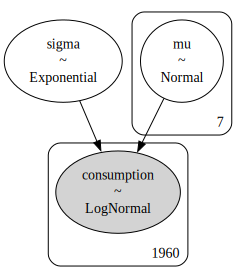

In [44]:
pm.model_graph.model_to_graphviz(model_simple)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

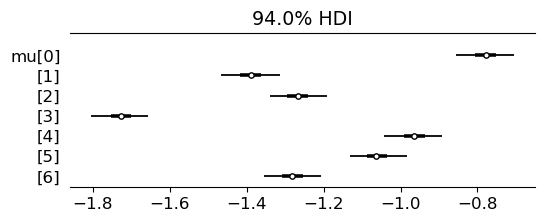

In [45]:
az.plot_forest(
    data = model_simple_trace, 
    colors = ["k"],
    kind = 'forestplot',
    # kind = 'ridgeplot',  # try ridgeplot instead for more information 
    var_names="mu", 
    hdi_prob=0.94, 
    combined = True, # plots the result for all four chains combined (try False)
    ridgeplot_alpha = .6,
    figsize = (6,2), 
    textsize = 12)

array([[<Axes: title={'center': 'mu\n0'}>,
        <Axes: title={'center': 'mu\n1'}>,
        <Axes: title={'center': 'mu\n2'}>],
       [<Axes: title={'center': 'mu\n3'}>,
        <Axes: title={'center': 'mu\n4'}>,
        <Axes: title={'center': 'mu\n5'}>],
       [<Axes: title={'center': 'mu\n6'}>, <Axes: >, <Axes: >]],
      dtype=object)

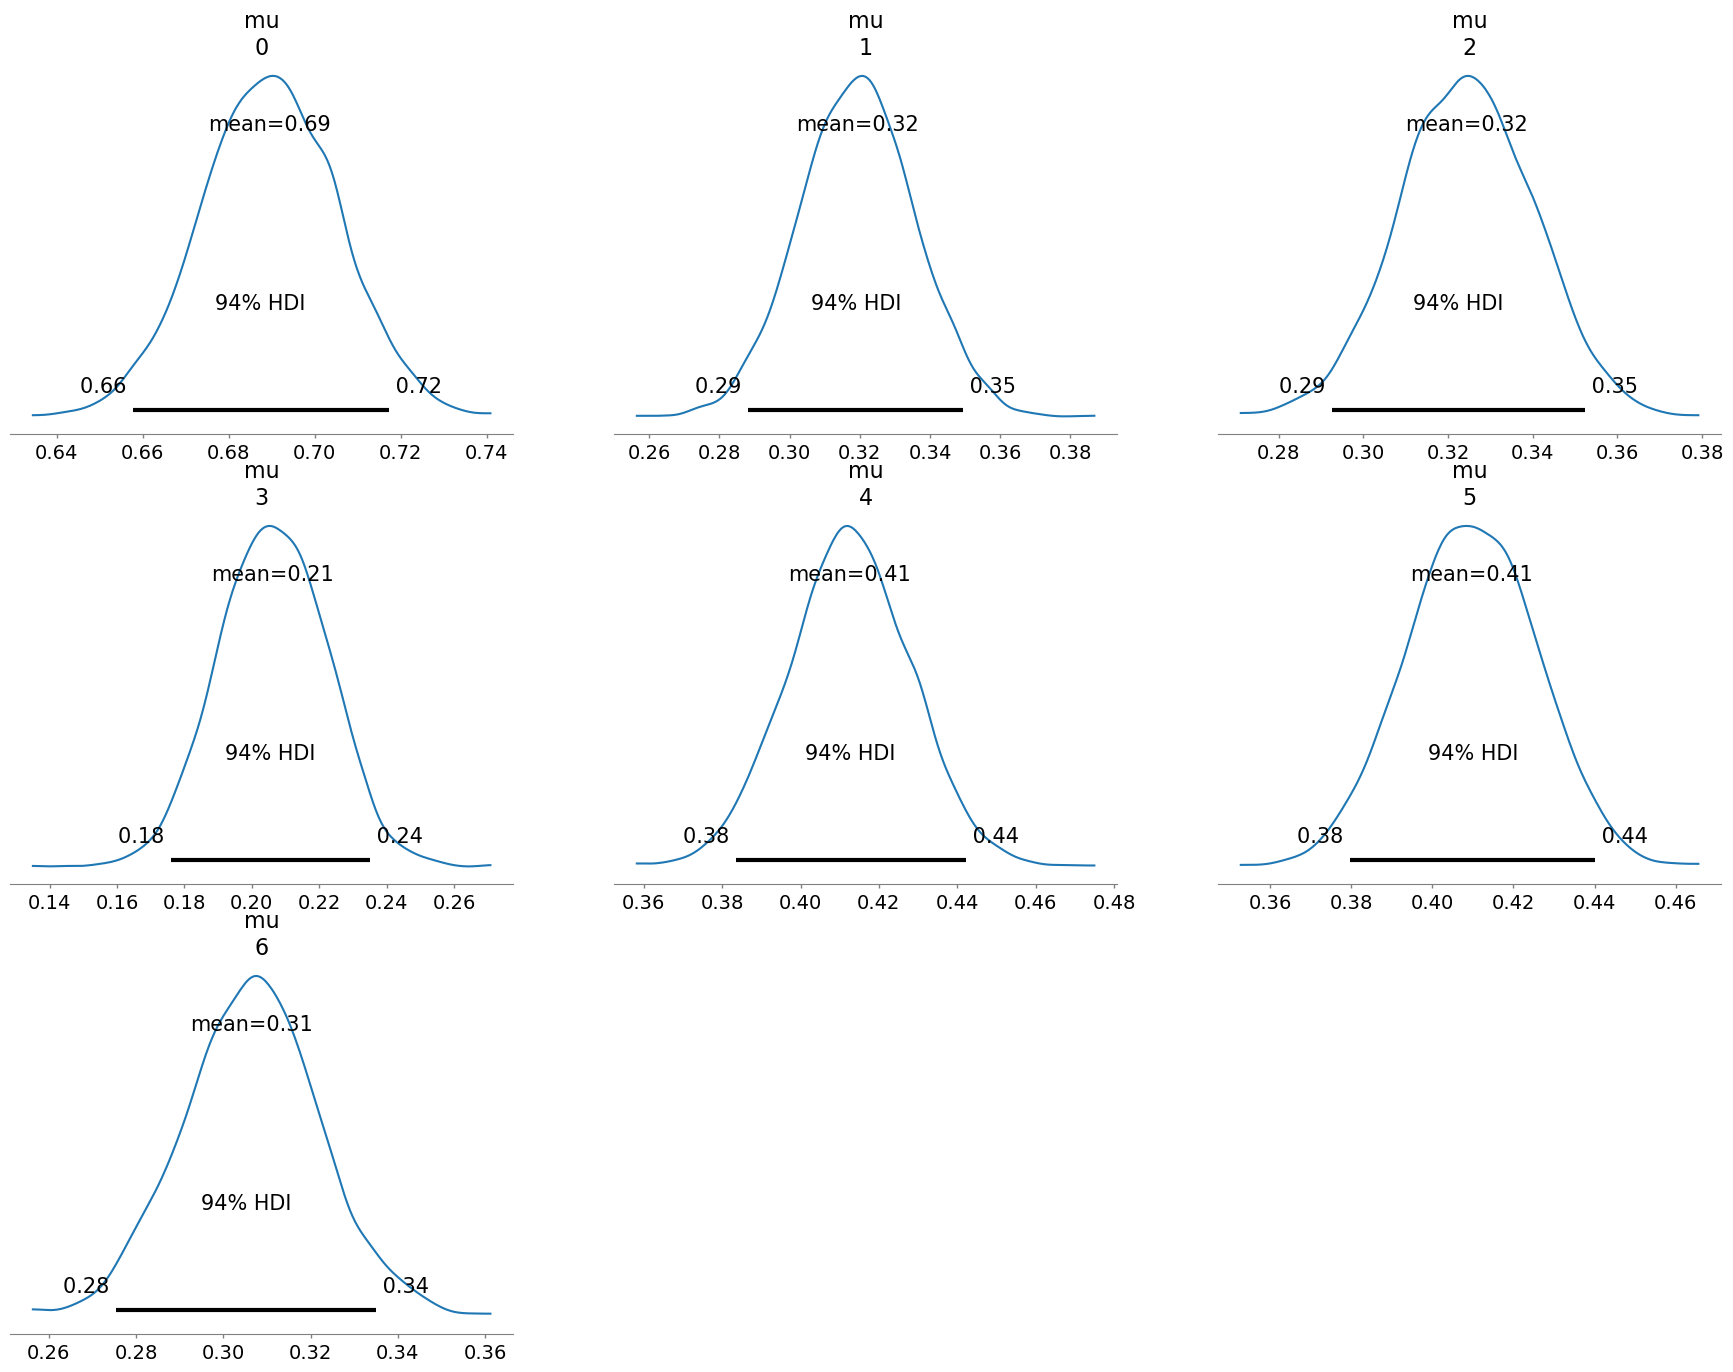

In [33]:
az.plot_posterior(model_simple_trace, var_names=["mu"], hdi_prob=0.94)

In [46]:
with model_simple:
    model_simple_trace.extend(pm.sample_prior_predictive(random_seed=rng))
    model_simple_trace.extend(pm.sample_posterior_predictive(model_simple_trace, random_seed=rng))

Sampling: [consumption, mu, sigma]
Sampling: [consumption]


Output()

<Axes: xlabel='consumption'>

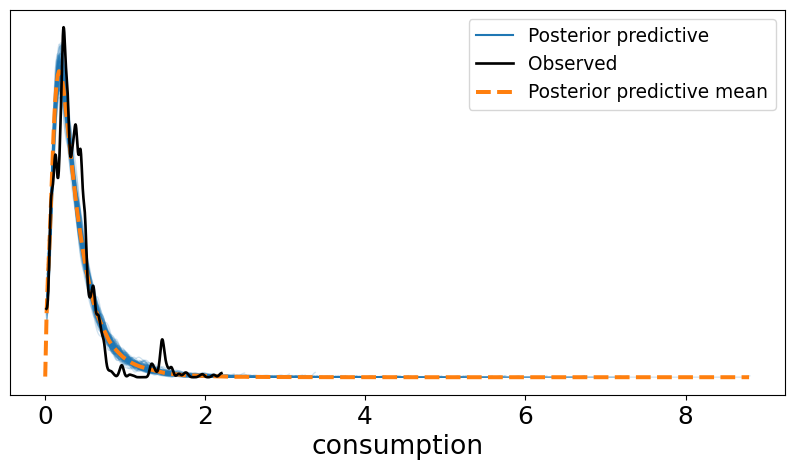

In [47]:
az.plot_ppc(model_simple_trace, num_pp_samples=100, figsize=(10, 5), random_seed=42)

In [48]:
az.summary(model_simple_trace, hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],-0.779,0.040,-0.855,-0.705,0.001,0.0,5302.0,3136.0,1.0
mu[1],-1.389,0.041,-1.467,-1.312,0.001,0.0,4840.0,3215.0,1.0
mu[2],-1.266,0.040,-1.340,-1.190,0.001,0.0,4937.0,3089.0,1.0
mu[3],-1.726,0.040,-1.803,-1.655,0.001,0.0,5567.0,3454.0,1.0
mu[4],-0.965,0.041,-1.043,-0.891,0.001,0.0,5001.0,2941.0,1.0
mu[5],-1.062,0.039,-1.131,-0.983,0.001,0.0,5158.0,3035.0,1.0
mu[6],-1.281,0.040,-1.354,-1.205,0.001,0.0,4741.0,2957.0,1.0
sigma,0.671,0.010,0.652,0.691,0.000,0.0,5483.0,3387.0,1.0


In [49]:
with model_simple:
    model_simple_trace.extend